In [ ]:
from pathlib import Path

import torch
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
import fitz
from uuid import uuid4
from PIL import Image
from io import BytesIO
import base64

import torch
from PIL import Image

from colpali_engine.models import ColQwen2, ColQwen2Processor
# from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

d:\folder\nornikel\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model_name = "vidore/colqwen2-v1.0"
device = 'cuda:0'

In [7]:
model = ColQwen2.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device,
).eval()
processor = ColQwen2Processor.from_pretrained(model_name)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.92s/it]


In [ ]:
qdrant_client = QdrantClient(
    url="http://localhost:6333", # https://cruel-singers-study.loca.lt
)

In [4]:
collection_name = "nornikel-docs"

In [ ]:
await qdrant_client.create_collection(
    collection_name=collection_name,
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=128,
        distance=models.Distance.COSINE,
        on_disk=True,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM,
        ),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True,
            ),
        ),
    ),
)

True

In [9]:
def upsert_to_qdrant(batch, collection_name):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=batch,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

In [10]:
def pdf_to_images(pdf_path):
    images = []
    pdf_document = fitz.open(pdf_path)
    try:
        for page_number in range(len(pdf_document)):
            page = pdf_document.load_page(page_number)

            pix = page.get_pixmap()

            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            images.append(img)
    finally:
        pdf_document.close()

    return images

In [9]:
def im_2_b64(image):
    buff = BytesIO()
    image.save(buff, format="JPEG")
    img_str = base64.b64encode(buff.getvalue())
    return img_str


def b64_2_img(data):
    buff = BytesIO(base64.b64decode(data))
    return Image.open(buff)

In [ ]:
def process_pdf(file_pth: Path, collection_name: str) -> None:
    images = pdf_to_images(file_pth)

    for img in tqdm(images):
        with torch.no_grad():
            batch_images = processor.process_images([img]).to(model.device)
            image_embeddings = model(**batch_images)

        for page, embedding in enumerate(image_embeddings, start=1):
            multivector = embedding.cpu().float().numpy().tolist()
            points = [
                models.PointStruct(
                    id=str(uuid4()),
                    vector=multivector,
                    payload={
                        'source': file_pth.name,
                        'page': str(page),
                        'image': im_2_b64(img),
                    },
                )
            ]

            upsert_to_qdrant(points, collection_name)


def process_docx(file_pth: Path, collection_name: str) -> None:
    file_pth = str(file_pth.absolute())
    # pdf_path = file_pth.removesuffix('.docx') + '.pdf'

    # import pypandoc
    # pypandoc.convert_file(file_pth, 'pdf', outputfile=pdf_path)

    # process_pdf(Path(pdf_path), collection_name)


In [ ]:
docs_dir = r"C:\Users\ledibruh\Downloads\RAG"
ext = {
    '.pdf': process_pdf,
    '.docx': process_docx,
}

for file_pth in Path(docs_dir).glob('*.pdf'):
    print('Processing', file_pth.name)
    process = ext.get(file_pth.suffix)
    if process is None:
        raise ValueError(f"Unknown file type: {file_pth.suffix}")
    process(file_pth, collection_name)

Processing 2022_Annual_Report_of_PJSC_MMC_Norilsk_Nickel_rus.pdf


100%|██████████| 192/192 [16:37<00:00,  5.19s/it]


Processing 2_5282802846297776741.pdf


100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


Processing 2_5366183129474161642.pdf


100%|██████████| 253/253 [04:10<00:00,  1.01it/s]


Processing Alrosa_Обзор_рынка_инвестиционных_бриллиантов_октябрь_2024.pdf


100%|██████████| 69/69 [03:58<00:00,  3.46s/it]


Processing digital_production_5.pdf


100%|██████████| 79/79 [04:28<00:00,  3.40s/it]


Processing Godovoi_-otchet-PAO-GMK-Norilskii_-nikel-za-2023-god.pdf


100%|██████████| 174/174 [14:47<00:00,  5.10s/it]


Processing K2Tex_x_TeДо_Российский_рынок_ИТ_2024_30_стр.pdf


100%|██████████| 30/30 [01:32<00:00,  3.09s/it]


Processing Kept_Золотодобывающие_компании_2024_25_стр.pdf


100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Processing Kept_Обзор_цен_в_металлургической_отрасли_2К2024.pdf


100%|██████████| 33/33 [00:22<00:00,  1.45it/s]


Processing KPMG_Global Metals & Mining_2024 (48 pgs).pdf


100%|██████████| 48/48 [02:28<00:00,  3.09s/it]


Processing McKinsey_Next Big Arenas_2024 (213 pgs).pdf


100%|██████████| 213/213 [03:11<00:00,  1.11it/s]


Processing NN_AR_2021_Book_RUS_26.09.22.pdf


100%|██████████| 181/181 [15:20<00:00,  5.09s/it]


Processing nn_climate_change_report_rus.pdf


100%|██████████| 39/39 [03:31<00:00,  5.42s/it]


Processing NN_CSO2021_RUS_03.03.2023.pdf


100%|██████████| 139/139 [11:29<00:00,  4.96s/it]


Processing nn_cso_2023_rus.pdf


100%|██████████| 246/246 [21:08<00:00,  5.16s/it]


Processing responsible_supply_chain_report_rus.pdf


100%|██████████| 18/18 [01:24<00:00,  4.67s/it]


Processing sr_ru_annual_report_pages_nornik_2022.pdf


100%|██████████| 191/191 [16:08<00:00,  5.07s/it]


Processing Доклад, уголь часть 1.pdf


100%|██████████| 25/25 [01:20<00:00,  3.23s/it]


Processing ММК 2024.pdf


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


Processing НЛМК 2024.pdf


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


Processing Норникель про корп культуру.pdf


100%|██████████| 11/11 [00:36<00:00,  3.36s/it]


Processing Норникель_Внутрення_цена_на_углерод.pdf


100%|██████████| 19/19 [01:04<00:00,  3.41s/it]


Processing Постановление_Правительства_РФ_от_16_02_2008_N_87_О_составе_разделов.pdf


100%|██████████| 119/119 [01:54<00:00,  1.04it/s]


Processing Росконгресс_Рынок_промышленных_роботов_в_мире_и_России_2024_16_стр.pdf


100%|██████████| 16/16 [00:52<00:00,  3.30s/it]


Processing СП_496_1325800_2020_Основания_и_фундаменты_зданий_и_сооружений.pdf


100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


Processing ТеДо_и_СУЭК_Перспективы_развития_экспорта_российского_угля_202.pdf


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


Processing Цифровизация_горно_металлургической_отрасли_России_в_2024_г_.pdf


100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


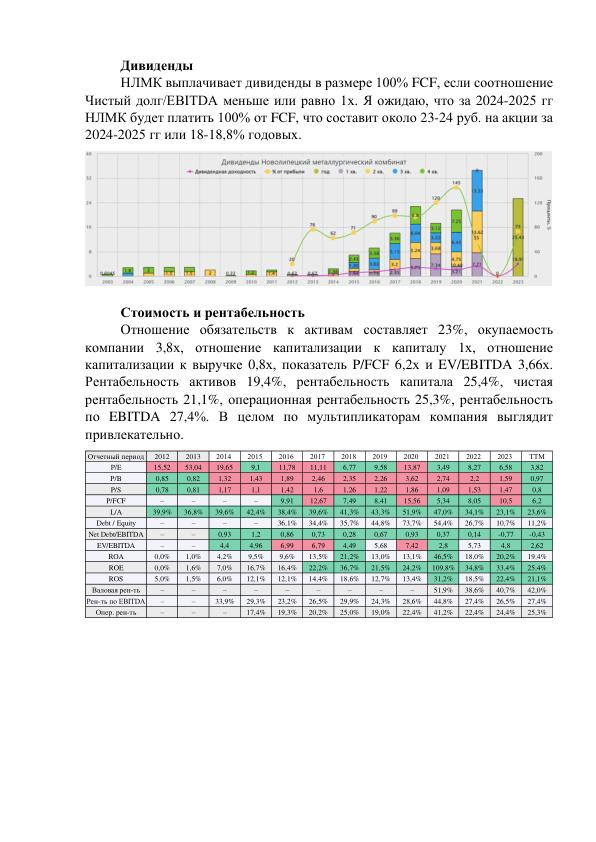

In [ ]:
query = 'Валовая рентабельность за 2023'

with torch.no_grad():
    batch_query = processor.process_queries([query]).to(model.device)
    query_embedding = model(**batch_query)

multivector_query = query_embedding[0].cpu().float().numpy().tolist()

search_result = qdrant_client.query_points(
    collection_name=collection_name,
    query=multivector_query,
    limit=10,
    timeout=100,
    search_params=models.SearchParams(
        quantization=models.QuantizationSearchParams(
            ignore=False,
            rescore=True,
            oversampling=2.0,
        )
    ),
)
b64_2_img(search_result.points[2].payload['image'])

In [11]:
search_result.points[0]

ScoredPoint(id='de2c38ca-aabc-4637-9ff4-e50f9bd1411a', version=5, score=16.846764, payload={'source': '2022_Annual_Report_of_PJSC_MMC_Norilsk_Nickel_rus.pdf', 'page': 1, 'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMaBOADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMB

# test llm

In [ ]:
base64_image = search_result.points[0].payload['image']
# base64_image = base64_image.decode('utf-8')

In [30]:
from openai import OpenAI

client = OpenAI(api_key='NO_KEY', base_url='http://localhost:23333/v1')
model_name = client.models.list().data[0].id
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {
            'role': 'system',
            'content': """
Ты - профессиональный ассистент, который помогает найти ответ в приложенных документах (например, изображения).
Ты должен помочь в анализе текста, картинок, графиков, схем, таблиц.
Сначала проанализируй приложенные документы, далее найди ответ на вопрос пользователя.

Следуй эти правилам:
1. Ответ должен быть четким и касающимся вопроса.
2. Не объясняй почему ты не нашел ответ.
3. Не нужно давать советов.
4. Будь вежлив.
5. Обдумывайте свои решения дважды.
""",
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image_url',
                    'image_url': {
                        'url': f"data:image/jpeg;base64,{base64_image}",
                    },
                },
                {
                    'type': 'text',
                    'text': 'Сколько % был EBITDA в 2014 отчетный период?',
                },
            ],
        }
    ],
    temperature=0.1,
    top_p=0.95,
    max_completion_tokens=64,
    
)

len(response.choices), response.choices[0].message.content

(1, 'EBITDA в 2014 отчетный период составлял 14 миллиардов рублей.')